In [1]:
# The Carbon data science platform in Jupyter

First we import a set of python libaries we will need for this demo

In [2]:
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import matplotlib.style
import time
import json
from IPython import display
from IPython.core.display import HTML
import pandas




The "sc" (SparkContext) object is the entry point for the Spark/Carbon

In [3]:
sql = SQLContext(sc) 

Define some functions

In [4]:

# Get the data we will be using. In this case we will get a parameterised number of minutes of Twitter data
def get_data(mins=1):
    now = int(time.time())
    min_ago = now - (mins * 60)
    
    # The call below creates the Spark DAG (Directed Acyclic Graph) on the cluster 
    return sql.read.load(format = "au.com.d2dcrc.carbon.spark.tweets", startTimestamp = min_ago, endTimestamp = now)
    
    
# Filter to only return true if "#auspol" is on body of text
def is_auspol(row):
    json_tweet = json.loads(row[0]) # parse the JSON
    
    # The JSON format is documented at http://support.gnip.com/sources/twitter/data_format.html
    body = json_tweet['body']
    
    if ('#auspol' in body.lower()):
        return True
    else:
        return False        


# Take a spark RDD of JSON-formatted Tweet data and convert the top rows in it to a Pandas table
def rdd_to_pandas_df(rdd, num_tweets=10):
    result = pandas.DataFrame()
    
    tweets = rdd.take(num_tweets)

    for row in tweets:
        json_tweet = json.loads(row[0]) # rows 0-2 are metadata 
        
        # extract the fields we are interested in
        data = pandas.DataFrame({"User Name": json_tweet['actor']['displayName'], 
                                 "Tweet": json_tweet['body']}, index=[0])        
        result = result.append(data)        
    
    return result 


## Using the system

Here we actually do something!

* Access the most recent set of data
* Count the number of tweets
* Filter for tweets about #auspol
* Count #auspol tweets
* Graph both counts
* Display a table of sample #auspol tweets


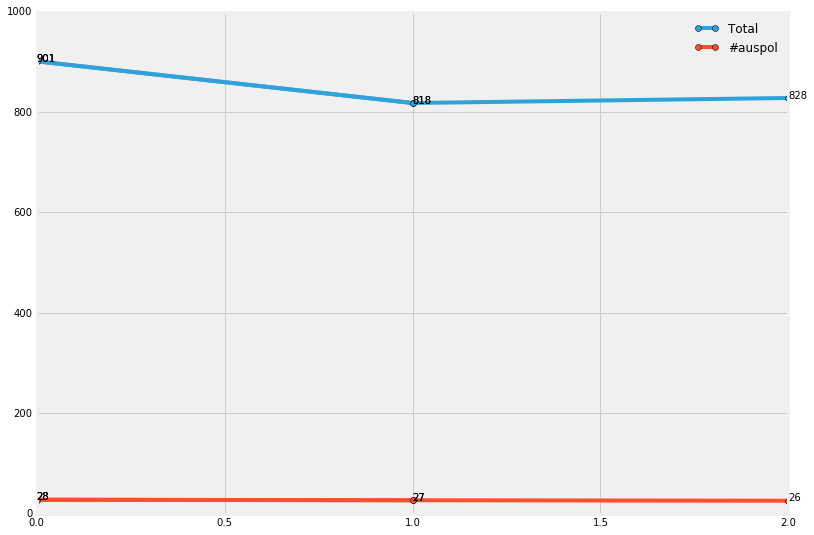

,Tweet,User Name
0,RT @StopShenhua: Ag &amp; Water Minister @Barnaby_Joyce exposed for his failure to stop the #Shenhua Mine while he holds office #auspol https:…,Janice
0,"""How dare #SafeSchools teach #LGBTQI students that their #sexuality is acceptable! We'll put a stop to THAT nonsense!"" - #LNP Govt #auspol",Peter Murphy
0,RT @workmanalice: So this happened to me during #SenateQT this week. #auspol https://t.co/IspWZjHveu https://t.co/8lgy4SG2p6,Rory
0,Join me in supporting the #HandsOffOurABC Campaign. #auspol https://t.co/wSz281kcvh,Vampressa
0,10/ The history of George Christensen #auspol #GChristensenLNP #LNP https://t.co/o37vzmDXFc,michael halliday777


In [5]:
display.display(HTML("<h1>Loading Data....</h1>"))

# Initialise the matplotlib graphing library and make it pretty
matplotlib.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(figsize=(12, 9))
ax = plt.axes()

# Set the width on the output table
pandas.set_option('display.max_colwidth', 200)

batches = []
values = []
auspol_values = []

# The batch size defines how many of minutes of data we grab
batch_size_in_minutes = 1

# Loop, getting data, processing it and displaying it
for i in range(0,3):
    display.clear_output(wait=True)  
    
    batches.append(i)
    
    # get a reference to the stored data data    
    df = get_data(batch_size_in_minutes)
        
    
    # get the count of records. This processing is done on the server
    count = df.count()    
    values.append(count)
    
    # We want count the number of records that reference #auspol    
    # First find these records
    # The DataFrame schema is documented in https://d2dcrc.atlassian.net/wiki/display/ARP/Persistence
    #
    # We want to run a Spark "filter" operation, which runs against a RDD, not a DataFrame
    # We convert the DataFrame to a RDD, then run the filter.
    #
    # Spark has a number of operations available. 
    # See http://spark.apache.org/docs/latest/programming-guide.html#transformations for a list
    auspol_rdd = df.select("data").rdd.filter(lambda row: is_auspol(row))
    
    # Now count them
    auspol_count = auspol_rdd.count()        
    auspol_values.append(auspol_count)
        

    # plot batch number vs count and auspol_count
    totals_line, = ax.plot(batches, values, "#30a2da", marker='o')    
    auspol_line, = ax.plot(batches, auspol_values, "#fc4f30", marker='o')    
    ax.legend([totals_line, auspol_line], ['Total', '#auspol'])
        
    
    for i in range(0, len(batches)):
        ax.annotate(str(values[i]), (batches[i], values[i]))
        ax.annotate(str(auspol_values[i]), (batches[i], auspol_values[i]))
        
    
    
    # get the first 5 tweets in the #auspol dataset as a sample
    tbl = rdd_to_pandas_df(auspol_rdd, 5)
    
    
    #plt.gcf(),
    
    # display all the data    
    display.display(HTML("<h1>Number of Tweets per " + str(batch_size_in_minutes) + " minute batch</h1>"),
                    plt.gcf(),
                    HTML("<h1>Sample #auspol Tweets</h1>"), 
                    tbl)
    
    # clear the display, BUT wait until there is something ready to display
    #display.clear_output(wait=True)   
        
    # Wait another batch_size_in_minutes 
    #   Note that this could miss data that was ingested while this processing loop was running
    #   Fixing that is left as an exercise for the reader
    
    time.sleep((batch_size_in_minutes - 1) * 60)
    
    
plt.close();